### 셀카 이미지 촬영
- 얼굴 인식 후 스티커를 붙일 자신의 사진을 촬영하여 가지고 온다.


- 스마트폰으로 세로로 찍은 사진과 가로로 찍은 사진들을 활용했다. <br> (세로로 찍은 경우 x의 값이 더 작고 가로로 찍은 경우 x의 값이 더 크다.)

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


### 1) 사진 이미지 가지고 오기

- 1. 사진을 cv2.imread로 가지고 온 후 사진 이미지가 너무 크므로 편의상 사용하기 좋게 파일의 크기를 조정한다. (cv2.resize())
<br>

  - 사진이 푸른색으로 나온 이유는 cv는 기존의 rgb채널을 bgr로 사용하기에 r->b, b->r 로 바꿔서 읽기에 생기는 문제다.
  
- 2. cv로 이미지를 가져왔으니 bgr 채널을 다시 rgb 채널로 바꿔워야 한다. (cv2.cvtColor())

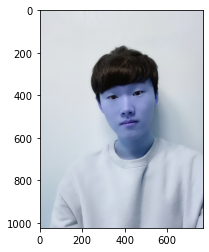

In [153]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽기 
img_bgr = cv2.resize(img_bgr, (768,1024))    # 768 x 1024의 크기로 Resize
#img_bgr = cv2.resize(img_bgr, (640,360))    # 768 x 1024의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

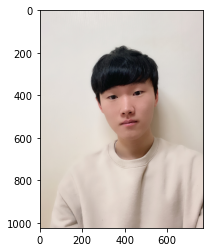

In [154]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 얼굴의 bounding box 그리기

face_detector 불러오기
boundgin box  추출
rectangles[[(241, 313) (562, 634)]]


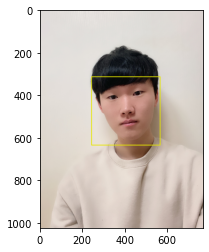

In [157]:
# hog detector
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("face_detector 불러오기")

# boundung box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("boundgin box  추출")

# 찾은 얼굴 영역 출력
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0, 230, 230), 2, lineType=cv2.LINE_AA)
    # 노란색 사각형으로 박스 그리기 (0, 230, 230) : 박스 색깔'
    # 2 : 박스 사각형 선의 크기
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 얼굴 랜드마크 검출하기

In [38]:
# dlib face detector 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("load_ face detector")

# 랜드마크 수 출력
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print("face landmark number : ",len(list_landmarks[0]))

load_ face detector
face landmark number :  68


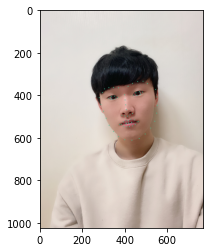

In [39]:
# 랜드마크 plt.imshow()에 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (152, 198, 60), -1) # dark green

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#  고양이 수염 스티커 적용 위치 확인하기
-  64개의 랜드마크를 기준으로 잡아서 넣고 싶은 위치의 벡터 값을 계산한다.

- 스티커 이미지가 (고양이 코 + 수염)이니 코 혹은 인중을 기준으로 잡는다.

- 얼굴의 각도에 따라 코의 위치가 변경이 되니 그에 맞게 값을 구해준다.
1. 고개를 왼쪽으로 꺽은 경우  Bounding center value < x [랜드마크 코 좌표 값]


2. 고개를 오른쪽으로 꺽은 경우  Bounding center value > x [랜드마크 코 좌표 값]


3. 얼굴 인식하는 부분을 박스의 크기와 맞게 두어서 박스의 center값이 코와 근접하게 만든다.  
  - (사람의 코는 얼굴의 중앙 부분에 위치하기에 해당 부분을 일치 시킨다.)


얼굴 위치에 따라서 계산할 수치
1. 스티커 위치

- 코끝값의 랜드마크를 구한 후 얼굴의 중앙 값에서 얼마나 떨어져 있는지 계산한 후 해당 위치를 조정한다.  (얼굴의 중앙값은 스티커의 중앙값과 동일하다. [Bounding box의 크기와 동일하게 만들어서 그렇다.])

- 위치를 조정할 때 값과 반대로 움직여야 해당 위치로 조정되니 (-1)을 곱한다.


- Bounding Box의 중앙값을 구하는 이유!! 고양이 스티커의 코를 기준으로 맞추어야 고양이 스티커와 어울리게 되는데 고양이 스티커의 약 절반쯤에 고양이 코부분이 있어서 얼굴 인식했을때 코끝부분을 해당 부분에 맞추어서 스티커를 붙여야 고개를 왼쪽이나 오른쪽으로 꺽어서 찍는 경우에도 어울리게 된다. 


값의 차이가 있을때 반대 방향으로 뺴줘야 하니 (-1)을 곱해서 반대 방향으로 만든다.

find_nose = ((-1)*(center.x - x)  , (-1)*(center.y-y) )   
find_t = t + find_nose[1]   
find_l = l + find_nose[0]  

```
2. 스티커 크기
```

##  $ width = height =width_{bbox}$

In [40]:
# 지정할 랜드마크 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # nose center index : 30
                        # 코 끝 위치 인덱스
    #x = landmark[33][0]
    x = landmark[33][0]   # 코 끝 값
    y = landmark[33][1] 
    #y = landmark[27][1]
    w = dlib_rect.width()
    h = dlib_rect.height()
    
    t = dlib_rect.top()
    b = dlib_rect.bottom()
    l = dlib_rect.left()
    center = dlib_rect.center()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    print(dlib_rect.top())
    print(l)
    print("center : ", center)  # bounding_box의 센터값 얼굴 인식했을때의 중앙 값

(409, 498)
(x,y) : (409,498)
(w,h) : (322,322)
313
241
center :  (402, 474)


## 위에서 결정한 크기를 기준으로 스티커 이미지를 넣는다.

In [41]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(322, 322, 3)


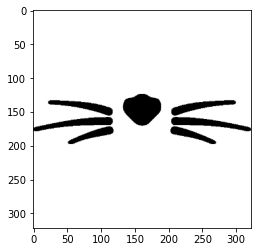

In [42]:
plt.imshow(img_sticker)

#### 고양이 스티커 좌표 테스트

In [13]:


# BoundingBox의 중앙값 -> 고양이 이미지의 중앙값 
# 이유 : 고양이 수염을 가지고 올 떄 BoundingBox 크기에 맞게 resize했기 때문

# 코는 일반적으로 사람의 얼굴을 세로로 봤을떄 중앙에 위치
# 고양이의 코가 중앙 보다 높은 값이기에 얼굴의 중앙 위치에서 조금 아래로 내리는게
# 깔끔하게 보여진다.

# 얼굴의 중앙[BoundingBox center]에서 코끝(33번)까지의 차이 만큼 세로 길이를 더해준다.
# Bounding box의 top , l 값에 고개의 각도에 따른 코끝에 위치 값을 뺴준다.

'''
w = dlib_rect.width()
h = dlib_rect.height()
    
t = dlib_rect.top()
b = dlib_rect.bottom()
l = dlib_rect.left()
center = dlib_rect.center()
'''
print("코 끝 (x,y) : (%d,%d)"%(x,y))
print("center (x,y) : (%d,%d)"%(center.x,center.y) )

# [center.x - x] 차이만큼 떨어진 위치에 있다는 의미이니 해당 위치로 옮겨주기 위해서 
# 나온 값의 반대 부호 방향으로 움직여야 한다.

# ex) x=200, center.x=190  (-10)의 차이가 있고 center를 기준으로 10만큼 움직여야 하는데 
# 음수 10인 경우 왼쪽으로 움직이기 때문에 (-1)를 곱해 움직이는 방향을 반대방향으로 바꾼다.

# 자기 손으로 찍은 셀카라는 가정하에

# 고개를 왼쪽으로 꺽은 경우 Bounding center value < x [랜드마크 코 좌표 값]

# 그와 반대로 center의 값이 크고 x의 값이 작은 양수 값이 나올떄는 얼굴인식 Bounding box에서
# 중앙 값과 실제 코에 위치가 차이가 +10 이므로 부호를 반대로 바꿔 왼쪽 방향으로 움직여 주어야 한다.

# 고개를 오른쪽으로 꺽은 경우 Bounding center value > x [랜드마크 코 좌표 값]

# 값의 차이에 따른 움직임이 반대이기에 -1을 곱한다.
find_nose = ((-1)*(center.x - x)  , (-1)*(center.y-y) ) 
find_t = t + find_nose[1]   
find_l = l + find_nose[0]

# 행렬 매트릭스로 이미지가 구성되니 x 좌표만 길게 늘려서 봤을때 (행벡터로)
# 높이와 같이 보이고  y좌표를 (열벡터)로 봤을때 너비와 같게 보인다.


print("refind_nose[0] :", find_nose[0])
print("refind_nose[1] :", find_nose[1])
print("refined_x :", find_t)
print("refined_y :", find_l)

print ('(x,y) : (%d,%d)'%(find_t, find_l))

코 끝 (x,y) : (409,498)
center (x,y) : (402,474)
refind_nose[0] : 7
refind_nose[1] : 24
refined_x : 337
refined_y : 248
(x,y) : (337,248)


In [43]:
# 원본 이미지에 스티커를 적용한다.
### image addWeighted 백업 아래
sticker_area = img_show[find_t:find_t+h, find_l:find_l+w]

# sticker의 범위 268 x 268을 맞춰서 가지고 온다.
img_show[find_t:find_t+h, find_l:find_l+w] = np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

#img_weight = cv2.addWeighted(img_show,0.2, img_sticker,0.8,0)

# np.where()는 where(조건식,참인 경우 반환, 아닌 경우 반환)
# 조건을 만족시키는 경우 참의 이미지를 반환 시켜 해당 이미지를 참의 이미지로 덯씌운다.
# 255이 아닌 값 부분을 사용하기 위해 img_sticker==255 를 사용

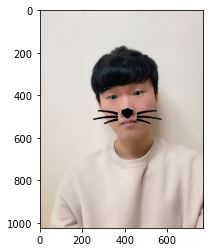

In [44]:
# 이미지 출력
#img_show=cv2.addWeighted(img_show,0.1,img_sticker,0.9,0)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### 얼굴의 코 좌표 계산 비교
1. 얼굴의 중앙값과 코 끝값의 차이를 계산한 후 스티커 위치 지정

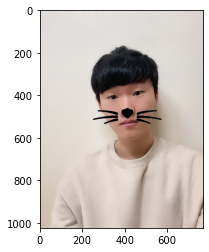

In [46]:
sticker_area = img_bgr[find_t:find_t+h, find_l:find_l+w]

# sticker의 범위 268 x 268을 맞춰서 가지고 온다.
img_bgr[find_t:find_t+h, find_l:find_l+w] = np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

2. 얼굴의 중앙에 코가 있으니 중앙 위치에 스티커 위치 지정
- 고양이 스티커와 코가 같이 보여 부 자연스러운 느낌을 준다.

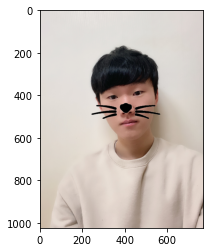

In [50]:
sticker_area = img_bgr[t:t+h, l:l+w]
img_bgr[t:t+h, l:l+w] = np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

#### 얼굴의 코 좌표 계산이 덜 정확할 경우
- 위에 사진이 좀 더 스티커가 매끄럽게 붙여져 있는것을 확인할 수 있다.

- 아래 이미지는 코 아래 콧구멍 부분이 보이지만 위 이미지는 코 아래 부분을 덮어서 더 자연스럽게 보인다.

### image addWeighted test
- 1. 이미지 얼굴 인식된 부분과, 고양이 부분을 따로 떼어서 두 이미지를 서로 가중치를 준 이미지를 생성한다. (image_weight)
- 2. 가중치가 들어간 이미지를 원본 img_show에 넣는다.

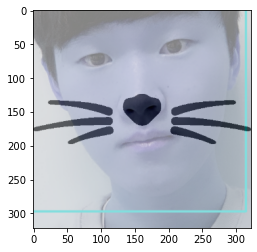

In [64]:
sticker_area = img_show[find_t:find_t+h, find_l:find_l+w]
image_weightTest = cv2.addWeighted(img_show[find_t:find_t+h, find_l:find_l+w], 0.4, img_sticker, 0.5,3)
plt.imshow(image_weightTest)
img_show[find_t:find_t+h, find_l:find_l+w] = np.where(img_sticker==255,sticker_area,image_weightTest).astype(np.uint8)

# np.where()는 where(조건식,참인 경우 반환, 아닌 경우 반환)
# 조건을 만족시키는 경우 참의 이미지를 반환 시켜 해당 이미지를 참의 이미지로 덯씌운다.
# 255이 아닌 값 부분을 사용하기 위해 img_sticker==255 를 사용

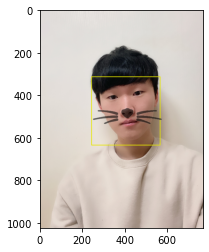

In [66]:
# 이미지 출력
#img_show=cv2.addWeighted(img_show,0.1,img_sticker,0.9,0)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 위의 가중치를 주지 않은 이미지보다 색이 덜 진하게 고양이 스티커가 들어간 것을 확인할 수 있다.

---
## 얼굴의 위치, 조명에 따른 고양이 스티커 확인하기

### 1. 일반 셀카보다 먼 거리 + 밝기에 따른 차이  
  (위의 사진을 일반 셀카를 찍을때 얼굴 크기로 가정하고 진행한다.)
- 밝은 경우 + 먼 거리

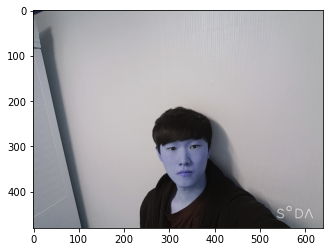

In [102]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_light.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽기 
img_bgr = cv2.resize(img_bgr, (640,480))    
# 640 x 360의 크기로 Resize할 시 랜드마크 검출 불가
# 얼굴의 비율이 깨져서 제대로 검출이 안된다.
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

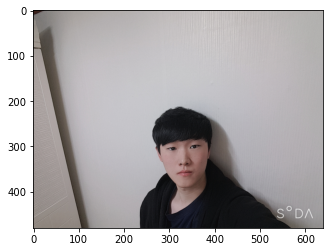

In [103]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 얼굴의 bounding box 그리기

face_detector 불러오기
boundgin box  추출
rectangles[[(282, 271) (390, 378)]]


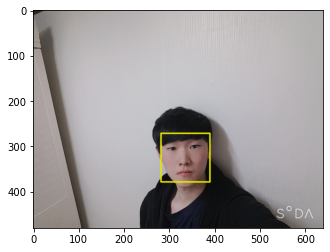

In [104]:
# hog detector
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("face_detector 불러오기")

# boundung box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("boundgin box  추출")

# 찾은 얼굴 영역 출력
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0, 230, 230), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 얼굴 랜드마크 검출하기

In [77]:
# dlib face detector 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("load_ face detector")

# 랜드마크 수 출력
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print("face landmark number : ",len(list_landmarks[0]))

load_ face detector
face landmark number :  68


In [80]:
# 지정할 랜드마크 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # nose center index : 30
                        # 코 끝 위치 인덱스

    x = landmark[33][0]   # 코 끝 값
    y = landmark[33][1] 

    w = dlib_rect.width()
    h = dlib_rect.height()
    
    t = dlib_rect.top()

    l = dlib_rect.left()
    center = dlib_rect.center()

    
    find_nose = ((-1)*(center.x - x)  , (-1)*(center.y-y) )  # 코 좌표 계산
    find_t = t + find_nose[1]   
    find_l = l + find_nose[0]
    
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    print(dlib_rect.top())
    print(l)
    print("center : ", center)  # bounding_box의 센터값 얼굴 인식했을때의 중앙 값

(333, 343)
(x,y) : (333,343)
(w,h) : (109,108)
271
282
center :  (336, 325)


## 위에서 결정한 크기를 기준으로 스티커 이미지를 넣는다.

In [81]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(108, 109, 3)


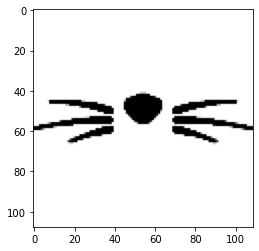

In [82]:
plt.imshow(img_sticker)

#### 고양이 스티커 사진에 붙이기

In [83]:
# 원본 이미지에 스티커를 적용한다.
sticker_area = img_show[find_t:find_t+h, find_l:find_l+w]

# sticker의 범위를 맞춰서 가지고 온다.
img_show[find_t:find_t+h, find_l:find_l+w] = np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


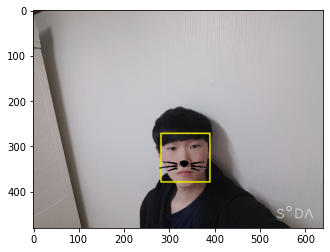

In [84]:
# 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 코 부분 스티커가 잘 붙었는지 Bounding Box부분을 가지고 와서 읽는다.


- 얼굴을 먼거리로 찍어서 고양이 스티커가 선 보다는 각이 있게 보인다.

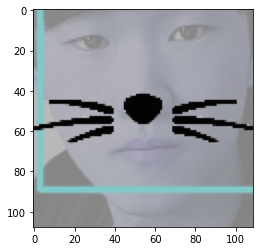

In [85]:
sticker_area = img_show[find_t:find_t+h, find_l:find_l+w]
image_weightTest = cv2.addWeighted(img_show[find_t:find_t+h, find_l:find_l+w], 0.3, img_sticker, 0.5,3)
plt.imshow(image_weightTest)


- 밝기는 위에 사진과 비슷해서 얼굴의 인식을 하는데 큰 영향이 있는것 같진 않지만, 거리가 더 멀게되니 고양이 스티커의 수염도 **뾰족하게**보이고 **사진의 비율**이 조금이라도 알맞은 비율이 아닌 경우 얼굴을 제대로 인식하지 못한다.


  - **사진 비율**에 따른 얼굴 인식 실패는 얼굴을 구성하는 픽셀이 작기에 발생하는 문제 같다.

---

### 1. 일반 셀카보다 먼 거리 + 밝기에 따른 차이  
  (위의 사진을 일반 셀카를 찍을때 얼굴 크기로 가정하고 진행한다.)

#### 위의 사진과 같은 사진이며, 밝기만 어둡게 편집한 사진이다.


- 어두운 경우 + 먼 거리

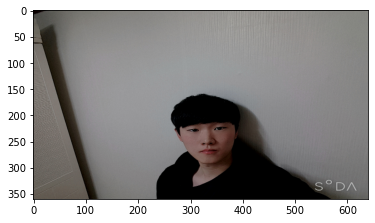

In [106]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_dark.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽기 
img_bgr = cv2.resize(img_bgr, (640,360))    
# 640 x 360의 크기로 Resize할 시 랜드마크 검출 불가
# 얼굴의 비율이 깨져서 제대로 검출이 안된다.
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 얼굴의 bounding box 그리기

face_detector 불러오기
boundgin box  추출
rectangles[[(282, 199) (390, 307)]]


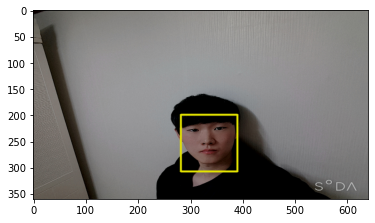

In [113]:
# hog detector
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("face_detector 불러오기")

# boundung box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("boundgin box  추출")

# 찾은 얼굴 영역 출력
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0, 230, 230), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

---



- 어두운 이미지에선 640x360이 인식이 되지만, 밝은 이미지 에선 얼굴의 랜드마크를 검출하지 못한다.

---

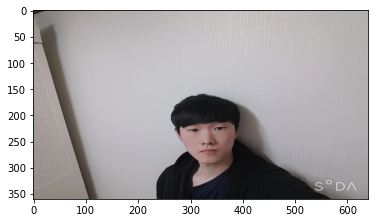

In [105]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_light.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽기 
img_bgr = cv2.resize(img_bgr, (640,360))    
# 640 x 360의 크기로 Resize할 시 랜드마크 검출 불가
# 얼굴의 비율이 깨져서 제대로 검출이 안된다.
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

face_detector 불러오기
boundgin box  추출
rectangles[]


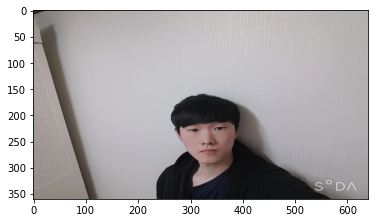

In [101]:
# hog detector
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("face_detector 불러오기")

# boundung box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("boundgin box  추출")

# 찾은 얼굴 영역 출력
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0, 230, 230), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

---

### 얼굴 랜드마크 검출하기

In [114]:
# dlib face detector 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("load_ face detector")

# 랜드마크 수 출력
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print("face landmark number : ",len(list_landmarks[0]))

load_ face detector
face landmark number :  68


In [115]:
# 지정할 랜드마크 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # nose center index : 30
                        # 코 끝 위치 인덱스

    x = landmark[33][0]   # 코 끝 값
    y = landmark[33][1] 

    w = dlib_rect.width()
    h = dlib_rect.height()
    
    t = dlib_rect.top()

    l = dlib_rect.left()
    center = dlib_rect.center()

    
    find_nose = ((-1)*(center.x - x)  , (-1)*(center.y-y) )  # 코 좌표 계산
    find_t = t + find_nose[1]   
    find_l = l + find_nose[0]

(334, 258)


In [117]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(109, 109, 3)


In [118]:
# 원본 이미지에 스티커를 적용한다.
sticker_area = img_show[find_t:find_t+h, find_l:find_l+w]

# sticker의 범위를 맞춰서 가지고 온다.
img_show[find_t:find_t+h, find_l:find_l+w] = np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


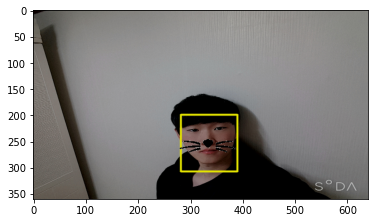

In [119]:
# 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 코 부분 스티커가 잘 붙었는지 Bounding Box부분을 가지고 와서 읽는다.


- 얼굴을 먼거리로 찍어서 고양이 스티커가 선 보다는 각이 있게 보인다.

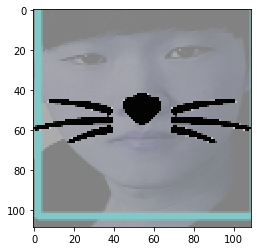

In [120]:
sticker_area = img_show[find_t:find_t+h, find_l:find_l+w]
image_weightTest = cv2.addWeighted(img_show[find_t:find_t+h, find_l:find_l+w], 0.3, img_sticker, 0.5,3)
plt.imshow(image_weightTest)


- 밝은 이미지 보다 어두운 이미지가 비율이 깨져도 얼굴인식이 잘된다는 것을 확인 했다.


- 한번만 가지고 답을 내리기는 이르니 좀 더 어두운 사진으로 테스트를 진행한다.
  - 어두운 사진이 생각보다 덜 어두운 느낌이 들어서 더 어둡게 편집한 후 얼굴인식이 잘되는지 테스트 진행


---
#### 더 어두운 사진으로 테스트 진행 

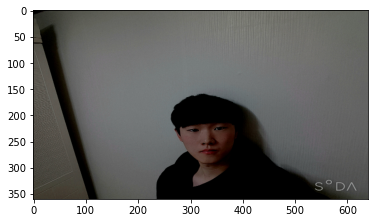

In [125]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_more_dark.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽기 
img_bgr = cv2.resize(img_bgr, (640,360))    

# 얼굴의 비율이 깨져서 제대로 검출이 안된다.
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

face_detector 불러오기
boundgin box  추출
rectangles[[(282, 187) (390, 295)]]


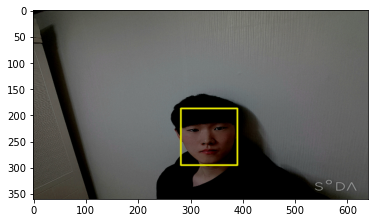

In [126]:
# hog detector
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("face_detector 불러오기")

# boundung box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("boundgin box  추출")

# 찾은 얼굴 영역 출력
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0, 230, 230), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

---

### 밝기에 따른 차이
- 조명이 어두울 수록 얼굴 랜드마크 검출이 더 잘이루어 진다.

### 거리에 따른 차이
- 거리가 멀 수록 이미지를 구성하는 **픽셀의 수가 적어서** 고양이 스티커 같은 경우 좀 더 **뾰족**하게 보인다.


---

### 2. 얼굴 각도에 따른 고양이 스티커

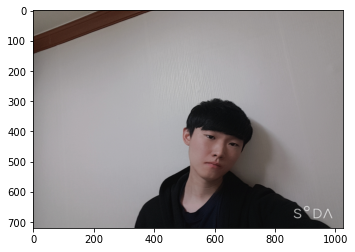

In [141]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_rotate.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽기 
#img_bgr = cv2.resize(img_bgr, (640,480))    
# 640 x 3480의 크기로 Resize할 시 랜드마크 검출 불가
img_bgr = cv2.resize(img_bgr, (1024,720))    
# 얼굴의 정보가 더 잘 확인할 수 있게 크기를 키웠다.

img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 얼굴의 bounding box 그리기

face_detector 불러오기
boundgin box  추출
rectangles[[(510, 366) (696, 552)]]


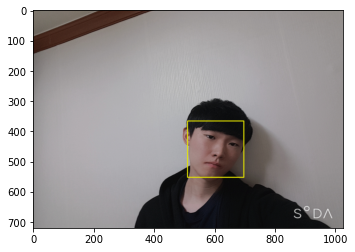

In [142]:
# hog detector
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("face_detector 불러오기")

# boundung box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("boundgin box  추출")

# 찾은 얼굴 영역 출력
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0, 230, 230), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

---
### 얼굴의 선명도(픽셀 값)이 작을시 랜드마크 검출 실패


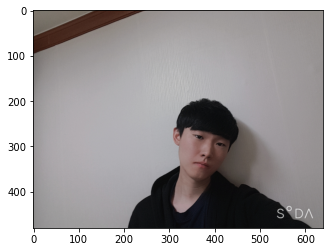

In [150]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_rotate.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽기 
img_bgr = cv2.resize(img_bgr, (640,480))    
# 640 x 3480의 크기로 Resize할 시 랜드마크 검출 불가

img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 얼굴의 bounding box 그리기

#### 얼굴이 왼쪽으로 기울어져서 제대로 인식을 하지 못하고 있다.

face_detector 불러오기
boundgin box  추출
rectangles[]


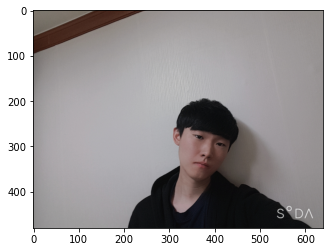

In [151]:
# hog detector
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
print("face_detector 불러오기")

# boundung box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
print("boundgin box  추출")

# 찾은 얼굴 영역 출력
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0, 230, 230), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

---

### 얼굴 랜드마크 검출하기

In [143]:
# dlib face detector 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("load_ face detector")

# 랜드마크 수 출력
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print("face landmark number : ",len(list_landmarks[0]))

load_ face detector
face landmark number :  68


In [144]:
# 지정할 랜드마크 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # nose center index : 30
                        # 코 끝 위치 인덱스
    x = landmark[33][0]   # 코 끝 값
    y = landmark[33][1] 

    w = dlib_rect.width()
    h = dlib_rect.height()
    
    t = dlib_rect.top()

    l = dlib_rect.left()
    center = dlib_rect.center()

    
    find_nose = ((-1)*(center.x - x)  , (-1)*(center.y-y) )  # 코 좌표 계산
    find_t = t + find_nose[1]   
    find_l = l + find_nose[0]
    
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    print(dlib_rect.top())
    print(l)
    print("center : ", center)  # bounding_box의 센터값 얼굴 인식했을때의 중앙 값

(611, 491)
(x,y) : (611,491)
(w,h) : (187,187)
366
510
center :  (603, 459)


## 위에서 결정한 크기를 기준으로 스티커 이미지를 넣는다.

In [145]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(187, 187, 3)


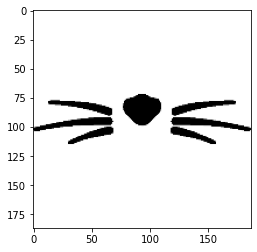

In [146]:
plt.imshow(img_sticker)

#### 고양이 스티커 사진에 붙이기

---

In [147]:
# 원본 이미지에 스티커를 적용한다.
sticker_area = img_show[find_t:find_t+h, find_l:find_l+w]

# sticker의 범위를 맞춰서 가지고 온다.
img_show[find_t:find_t+h, find_l:find_l+w] = np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)


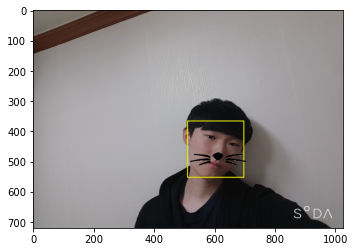

In [148]:
# 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 코 부분 스티커가 잘 붙었는지 Bounding Box부분을 가지고 와서 읽는다.


- 얼굴을 먼거리로 찍어서 고양이 스티커가 선 보다는 각이 있게 보인다.

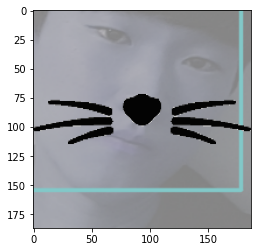

In [149]:
sticker_area = img_show[find_t:find_t+h, find_l:find_l+w]
image_weightTest = cv2.addWeighted(img_show[find_t:find_t+h, find_l:find_l+w], 0.3, img_sticker, 0.5,3)
plt.imshow(image_weightTest)


#### 각도에 따른 차이
- 얼굴의 각도가 클 수록 더 선명한(픽셀 값이 큰) 사진으로 해야 얼굴의 랜드마크 검출이 제대로 이루어 진다 


- 추가로, 코 계산할 때 코의 위치는 제대로 찾아서 수염이 가긴 했지만, 정면 각도를 기준으로 했기에 얼굴이 기울어졌을때의 코의 위치가 얼굴의 각도를 따라 회전하지는 않는다.

---

### 회고
- 개인적으로 아쉬웠던 점이 있다. 얼굴의 위치에 따른 계산을 할 때 각도까지 계산해서 왼쪽으로 기울어 졌을때는 그만큼 고양이 스티커도 기울여서 붙이고, 오른쪽일 때는 또 그만큼 기울여서 붙이고 싶었다. 그렇게 따로 테스트를 계속 하다가 일요일까지 오게 되었는데 더이상 지체하면 나머지 해야할 것도 제대로 못하고 시간만 보낼것 같아서 각도 계산을 못하고 마무리를 한게 너무 아쉽습니다.


- 그리고 개인적으로 지금까지 했던 모든 프로젝트들 중에서 가장 머리를 많이 써야했고 어려웠던것 같습니다. 코 위치 계산 부분이 될것 같으면서 안되니까 너무 스트레스가 났습니다. <br>거기다 가중치 주는 방법도 가중치를 줄 부분을 떼어서 가중치를 준 후 다시 붙이기 하는게 바로 생각이 안났어서 하는데 시간이 걸렸습니다.


- 그래도 제 얼굴 사진으로 진행하니 좀 더 직관적이기도 해서 그 부분은 좋았습니다.
  - ~~다른 사람이 볼 수 있는 gitHub에 올라가니 머리를 만지거나 했지만, 맘에 드는 사진이 없어서 조금 슬프네요...~~
  
- 처음 프로젝트를 진행할 때는 스노우와 같은 얼굴 스티커를 붙이는 앱들을 이미 많이 접했어서 얼굴의 스티커 이미지를 붙이는게 간단해 보였지만, 직접 해보니 눈, 코, 입 등의 좌표를 찾아서 계산하고 스티커를 붙이는게 많이 어렵구나 하는 생각이 들었습니다.